In [1]:
assay_index = 1

In [2]:
import pandas as pd
!gsutil cp gs://chem_dsrc/P0_Toxcast/Data/assay_df/*_df.csv ./

Copying gs://chem_dsrc/P0_Toxcast/Data/assay_df/335_all_assay_df.csv...
Copying gs://chem_dsrc/P0_Toxcast/Data/assay_df/NCCT_TPO_AUR_dn_df.csv...
Copying gs://chem_dsrc/P0_Toxcast/Data/assay_df/NVS_ADME_hCYP1A2_df.csv...
Copying gs://chem_dsrc/P0_Toxcast/Data/assay_df/NVS_ADME_hCYP2B6_df.csv...
/ [4 files][  4.3 MiB/  4.3 MiB]                                                
Operation completed over 4 objects/4.3 MiB.                                      


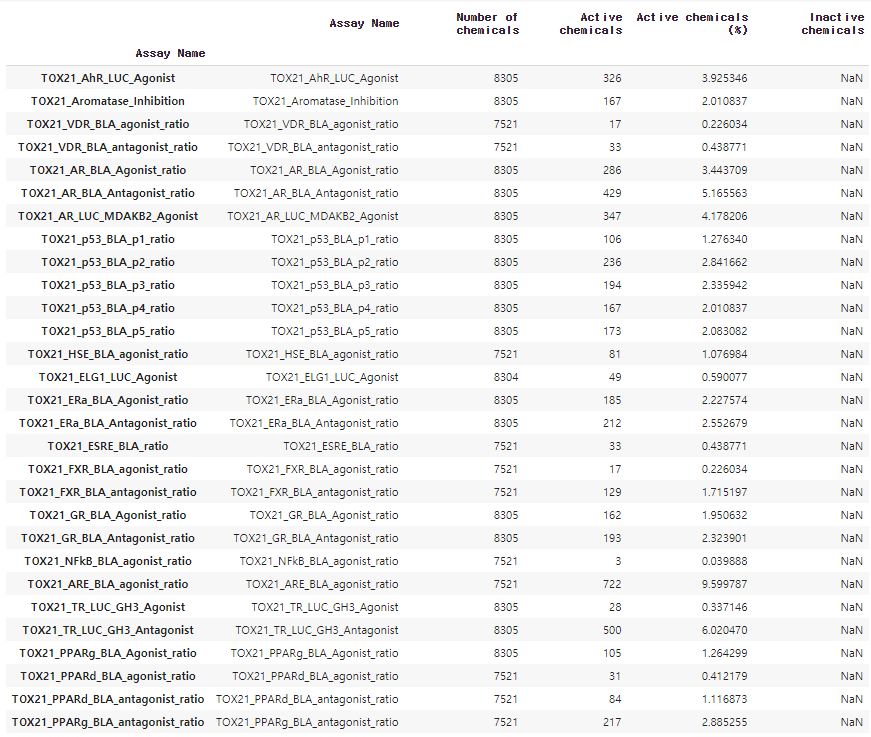

In [3]:
selected_assay_list = ['TOX21_AhR_LUC_Agonist', 'TOX21_Aromatase_Inhibition', 'TOX21_VDR_BLA_agonist_ratio', 'TOX21_VDR_BLA_antagonist_ratio', 'TOX21_AR_BLA_Agonist_ratio', 'TOX21_AR_BLA_Antagonist_ratio', 'TOX21_AR_LUC_MDAKB2_Agonist', 'TOX21_p53_BLA_p1_ratio', 'TOX21_p53_BLA_p2_ratio', 'TOX21_p53_BLA_p3_ratio', 'TOX21_p53_BLA_p4_ratio', 'TOX21_p53_BLA_p5_ratio', 'TOX21_HSE_BLA_agonist_ratio', 'TOX21_ELG1_LUC_Agonist', 'TOX21_ERa_BLA_Agonist_ratio', 'TOX21_ERa_BLA_Antagonist_ratio', 'TOX21_ESRE_BLA_ratio', 'TOX21_FXR_BLA_agonist_ratio', 'TOX21_FXR_BLA_antagonist_ratio', 'TOX21_GR_BLA_Agonist_ratio', 'TOX21_GR_BLA_Antagonist_ratio', 'TOX21_NFkB_BLA_agonist_ratio', 'TOX21_ARE_BLA_agonist_ratio', 'TOX21_TR_LUC_GH3_Agonist', 'TOX21_TR_LUC_GH3_Antagonist', 'TOX21_PPARg_BLA_Agonist_ratio', 'TOX21_PPARd_BLA_agonist_ratio', 'TOX21_PPARd_BLA_antagonist_ratio', 'TOX21_PPARg_BLA_antagonist_ratio']

In [4]:
selected_assay_list.remove('TOX21_NFkB_BLA_agonist_ratio') #active물질 개수가 3개뿐인 assay라 모델 

In [5]:
assay_name = '335_all_assay'
df = pd.read_csv(assay_name+"_df.csv")

In [6]:
df

Unnamed: 0 TOX21_AhR_LUC_Agonist  ... NVS_NR_hPPARg NVS_NR_hPPARa
0         100-00-5                     N  ...             N           NaN
1        1000-05-1                     N  ...           NaN           NaN
2       10001-13-5                     N  ...           NaN           NaN
3         100-01-6                     N  ...           NaN           NaN
4         100-02-7                     N  ...             N           NaN
...            ...                   ...  ...           ...           ...
9219  NOCAS_903892                   NaN  ...           NaN           NaN
9220  NOCAS_903893                   NaN  ...           NaN           NaN
9221  NOCAS_903894                   NaN  ...           NaN           NaN
9222  NOCAS_903895                   NaN  ...           NaN           NaN
9223  NOCAS_903896                   NaN  ...           NaN           NaN

[9224 rows x 337 columns]

In [7]:
ss = selected_assay_list[assay_index] # 그룹
a_i = 0 # assay index
ffpp = "maccs"

In [8]:
# rdkit 2020.03.3 버전 다운로드
!pip install kora -q
import kora.install.rdkit
!pip install pycaret
from pycaret.classification import *
import numpy
import pandas
import numpy as np
import pandas as pd

from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit import DataStructs
from rdkit.Chem import Draw
from rdkit.Chem.Draw import SimilarityMaps
from rdkit import Chem, DataStructs
from rdkit.Chem import MACCSkeys

     |████████████████████████████████| 61kB 3.4MB/s 
     |████████████████████████████████| 61kB 6.6MB/s 
     |████████████████████████████████| 266kB 6.5MB/s 
     |████████████████████████████████| 215kB 8.2MB/s 
     |████████████████████████████████| 1.7MB 8.7MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 245kB 22.3MB/s 
     |████████████████████████████████| 2.0MB 15.6MB/s 
     |████████████████████████████████| 6.8MB 48.8MB/s 
     |████████████████████████████████| 81kB 7.7MB/s 
     |████████████████████████████████| 276kB 49.3MB/s 
     |████████████████████████████████| 61kB 6.6MB/s 
     |████████████████████████████████| 102kB 11.0MB/s 
     |████████████████████████████████| 14.2MB 47.5MB/s 
     |████████████████████████████████| 61kB 6.3MB/s 
     |████████████████████████████████| 81kB 8.0MB/s 
     

In [9]:
from pycaret.utils import enable_colab
enable_colab() #to display interactive visuals.

Colab mode enabled.


In [10]:
df_ss = df.loc[:,['smiles',ss]]
df_ss = df_ss.dropna()

In [11]:
assays_ss = df_ss.columns

In [12]:
assays_ss

Index(['smiles', 'TOX21_Aromatase_Inhibition'], dtype='object')

In [13]:
from imblearn.combine import SMOTEENN 
sme = SMOTEENN(random_state=42,sampling_strategy = "minority")

In [14]:
ss

'TOX21_Aromatase_Inhibition'

In [15]:
#Smiles --> MACCS Keys
assay = ss
df_train  = df_ss[['smiles',ss] ]

smiles_list = []
err_smiles = []# fingerfrint로 변환시 에러 smiles
fps = []
enc_y = []
for index, row in df_train.iterrows():

  if row[-1] == 'N' : 
    target = 0
  else :
    target = 1

  try : 
    mol = Chem.MolFromSmiles(row['smiles'])
    
    if ffpp == 'maccs' :    
        fp = MACCSkeys.GenMACCSKeys(mol)
    elif ffpp == 'morgan' : 
        fp = Chem.AllChem.GetMorganFingerprintAsBitVect(mol, 2)
    elif ffpp == 'rdkit' : 
        fp = Chem.RDKFingerprint(mol)
    elif ffpp == 'pattern' : 
        fp = Chem.rdmolops.PatternFingerprint(mol)
    elif ffpp == 'layerd' : 
        fp = Chem.rdmolops.LayeredFingerprint(mol)
    else : 
        print("fingerfrint selection error!")
        
    smiles_list.append(row['smiles'])   
    fps.append(fp)
    enc_y.append(target)
  except : 
    err_smiles.append(row['smiles'])
    pass

np_fps = []
for fp in fps:
  arr = numpy.zeros((1,))
  DataStructs.ConvertToNumpyArray(fp, arr)
  np_fps.append(arr)

np_fps_array = numpy.array(np_fps)

print("변환 에러난 smiles 개수 : ", len(err_smiles), err_smiles)

x_train_res, y_train_res = np_fps_array, np.array(enc_y)
train = pd.DataFrame(data=x_train_res)
train['label'] = y_train_res

변환 에러난 smiles 개수 :  9 ['[F-][B+3]([F-])([F-])[F-].CC[N+]1(C)CCCC1', 'CC1C=C[C-](=C1)[Mn+]([C-]#[O+])([C-]#[O+])[C-]#[O+]', '[H][O]1[Au+][S-]C2O[C@H](CO)[C@@H](O)[C@H](O)[C@@]12[H]', '[O-]1N2C=CC=CC2=[S][Zn++]11[O-]N2C=CC=CC2=[S]1', '[H][N]([H])([H])[Pt++]([Cl-])([Cl-])[N]([H])([H])[H]', '[Na+].[Na+].F[Si--](F)(F)(F)(F)F', '[NH4+].[NH4+].F[Si--](F)(F)(F)(F)F', '[H][N]([H])([H])[Pt++]1([O-]C(=O)C2(CCC2)C(=O)[O-]1)[N]([H])([H])[H]', 'C[Sn](C)(|[O]C(=O)CCCCCC(C)(C)C)|[O]C(=O)CCCCCC(C)(C)C']


In [16]:
d = pd.DataFrame(columns = ['smiles','Type'] )
d['smiles'] = smiles_list
d['Type'] = enc_y

In [17]:
d

smiles  Type
0                           [O-][N+](=O)C1=CC=C(Cl)C=C1     0
1             C[SiH](C)O[Si](C)(C)O[Si](C)(C)O[SiH](C)C     0
2                              CN1CCN(CC1)C(=O)C1CCCCC1     0
3                            NC1=CC=C(C=C1)[N+]([O-])=O     0
4                            OC1=CC=C(C=C1)[N+]([O-])=O     0
...                                                 ...   ...
8131    FC1=CC(Br)=C(C=C1)C(=O)NS(=O)(=O)\C=C\C1=CC=CS1     0
8132  OC(=O)C(F)(F)F.CCN(CC)C(=O)C1=C(C=C(N2CCC(CC2)...     0
8133  NC1=CC=C(C(O)=O)C(O)=C1.CN(C)CCOC1=CC=CC=C1CC1...     0
8134  CC(=O)NC1=NC(=O)N(C=C1)C1COC(COC(=O)C2=CC=CC=C...     0
8135  OC(=O)\C=C\C(O)=O.CCN(CC)CCC1=CNC2=CC=CC=C12.C...     0

[8136 rows x 2 columns]

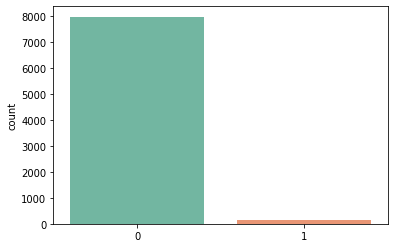

In [18]:
import seaborn as sns
sns.countplot(enc_y, palette="Set2") #팔레트를 이렇게 바꿀수 있구나.

In [19]:
#모든 물질에 대한 fingerprint를 string형태로 바꾼다(비교하기위함).
mychems = []
for item in np_fps:
    #print(item)
    item = np.array(item,dtype=int) #왜 굳이 두번? int형으로 추가하려면 이렇게 하면 되는구나....
    s = item.tolist() #넘파이어레이를 리스트로 바꾼다. 
    t = [str(i) for i in s]
    mychems.append(''.join(t))

In [20]:
i = 0
counter = 0
chemdict = {} #딗셔너리.
listofdups = []
for item in mychems:
    try:
        chemdict[str(item)].append(i)
        #print('dup found')
        for j in range(len(chemdict[str(item)])):
            if (d['Type'][i] != d['Type'][chemdict[str(item)][j]]) :
                listofdups.append(i)
                counter+=1
    except: 
        #print('adding new')
        chemdict[str(item)] = []
        chemdict[str(item)].append(i)
    i+=1
print(str(counter)+' '+str(len(list(set(listofdups)))))
#smote적용하기 전에서 listofdups를 빼면 된다!


51 34


In [21]:
dups_list = list(set(listofdups))

In [22]:
dups_list # 0인것만 지우는게 맞나?

[3968,
 3587,
 3588,
 5252,
 4230,
 7561,
 2836,
 2837,
 2838,
 5788,
 1789,
 4400,
 2356,
 6327,
 4161,
 6214,
 2892,
 6098,
 3032,
 5210,
 4317,
 5854,
 7519,
 4449,
 4322,
 4198,
 4199,
 4200,
 4201,
 6631,
 7144,
 7401,
 3068,
 3069]

In [23]:
dups_list_0 = []
for index in dups_list : 
  if train.iloc[index].label == 0 :
    dups_list_0.append(index)

In [24]:
train = train.drop(dups_list_0)

In [25]:
train

0    1    2    3    4    5    6    7    8    9   10   11   12   13  \
0     0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
1     0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
2     0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
3     0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
4     0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
...   ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...   
8131  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
8132  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
8133  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
8134  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
8135  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   

       14   15   16   17   18   19   20   21   22   23   24   25   26   27  \
0     0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0   
1     0.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
2     0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
3     0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0   
4     0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0   
...   ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...   
8131  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
8132  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
8133  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
8134  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
8135  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   

       28   29   30   31   32   33   34   35   36   37   38   39   40   41  \
0     0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
1     0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
2     0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
3     0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
4     0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
...   ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...   
8131  0.0  0.0  0.0  0.0  1.0  1.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0  0.0   
8132  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
8133  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
8134  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  1.0  0.0  0.0  0.0   
8135  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   

       42   43   44   45   46   47   48   49   50   51   52   53   54   55  \
0     0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0   
1     0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
2     0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
3     0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0   
4     0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0   
...   ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...   
8131  1.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0  1.0   
8132  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0  1.0   
8133  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0   
8134  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
8135  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   

       56   57   58   59   60   61   62   63   64   65   66   67   68   69  \
0     1.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0   
1     0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0   
2     0.0  0.0  0.0  0.0  

In [26]:
len(smiles_list)

8136

In [27]:
duplicated_smiles_0_df = pd.DataFrame()
duplicated_smiles_0_df['deleted_duplicate_smiles_0'] = smiles_list
duplicated_smiles_0_df = duplicated_smiles_0_df.iloc[dups_list_0,]
duplicated_smiles_0_df

deleted_duplicate_smiles_0
3968       F[P-](F)(F)(F)(F)F.CCCCCCCCCCN1C=C[N+](C)=C1
3587           F[P-](F)(F)(F)(F)F.CCCCCCN1C=C[N+](C)=C1
3588         F[P-](F)(F)(F)(F)F.CCCCCCCCN1C=C[N+](C)=C1
4230    [O-]S(=O)(=O)C(F)(F)F.CCCCCCCCCCN1C=C[N+](C)=C1
7561   CC(=O)O[Sn](C1=CC=CC=C1)(C1=CC=CC=C1)C1=CC=CC=C1
2836   F[P-](F)(F)(F)(F)F.CCCCCCCCCCCCCCN1C=C[N+](C)=C1
2837  F[P-](F)(F)(F)(F)F.CCCCCCCCCCCCCCCCN1C=C[N+](C...
5788              [Cl-].CCCCCCCCCCCCCCCCN1C=C[N+](C)=C1
4400        [O-]S(=O)(=O)C(F)(F)F.CCCCCCN1C=C[N+](C)=C1
4161  [O-][N+](=O)C1=CC(=CC(=C1Cl)[N+]([O-])=O)C(F)(F)F
6214                 CC(=C)C(=O)OCCCCCCCCCCOC(=O)C(C)=C
2892                            NC1=CC=CC2=C(N)C=CC=C12
6098                      [Cl-].CCCCCCCCN1C=C[N+](C)=C1
4317                              CC1=C(C=O)C(C)(C)CCC1
5854                         [Cl-].CCCCCC[N+]1=CC=CC=C1
7519                     NC1=C(C=C(Cl)C=C1)[N+]([O-])=O
4322  FC(F)(F)S(=O)(=O)[N-]S(=O)(=O)C(F)(F)F.CCCCCCC...
6631                         [Br-].CCCCCC[N+]1=CC=CC=C1
7401          CCC1=C(N([C@@H](C)COC)C(=O)CCl)C(C)=CC=C1

In [28]:
save_path = 'gs://chem_dsrc/P0_Toxcast/result/29assays_dd/'

In [29]:
dupdf = ss+"_dup_smiles_df.csv"
duplicated_smiles_0_df.to_csv(dupdf)
duppath = save_path + 'err_smiles/'
!gsutil cp $dupdf $duppath

Copying file://TOX21_Aromatase_Inhibition_dup_smiles_df.csv [Content-Type=text/csv]...
/ [1 files][  884.0 B/  884.0 B]                                                
Operation completed over 1 objects/884.0 B.                                      


In [30]:
import pandas as pd
err_smiles_df = pd.DataFrame(columns = [ss], index = ['err_n','err_smiles'])
err_smiles_df[ss] = [ len(err_smiles), err_smiles]

In [31]:
ersdf = ss+"_err_smiles_df.csv"
err_smiles_df.to_csv(ersdf)
errpath = save_path + 'err_smiles/'
!gsutil cp $ersdf $errpath $errpath

Copying file://TOX21_Aromatase_Inhibition_err_smiles_df.csv [Content-Type=text/csv]...
Omitting prefix "gs://chem_dsrc/P0_Toxcast/result/29assays_dd/err_smiles/". (Did you mean to do cp -r?)

Operation completed over 1 objects/519.0 B.                                      


In [32]:
err_smiles_df

TOX21_Aromatase_Inhibition
err_n                                                       9
err_smiles  [[F-][B+3]([F-])([F-])[F-].CC[N+]1(C)CCCC1, CC...

In [33]:
# clf = setup(data = train, target = 'label') 
clf = setup(data = train, target = 'label', fix_imbalance = True, fix_imbalance_method = sme
            ,train_size = 0.9
            ,use_gpu =True
            ,session_id=123) 

Description             Value
0                               session_id               123
1                                   Target             label
2                              Target Type            Binary
3                            Label Encoded        0: 0, 1: 1
4                            Original Data       (8117, 168)
5                           Missing Values             False
6                         Numeric Features                 4
7                     Categorical Features               163
8                         Ordinal Features             False
9                High Cardinality Features             False
10                 High Cardinality Method              None
11                   Transformed Train Set       (7305, 160)
12                    Transformed Test Set        (812, 160)
13                      Shuffle Train-Test              True
14                     Stratify Train-Test             False
15                          Fold Generator   StratifiedKFold
16                             Fold Number                10
17                                CPU Jobs                -1
18                                 Use GPU              True
19                          Log Experiment             False
20                         Experiment Name  clf-default-name
21                                     USI              4c91
22                         Imputation Type            simple
23          Iterative Imputation Iteration              None
24                         Numeric Imputer              mean
25      Iterative Imputation Numeric Model              None
26                     Categorical Imputer          constant
27  Iterative Imputation Categorical Model              None
28           Unknown Categoricals Handling    least_frequent
29                               Normalize             False
30                        Normalize Method              None
31                          Transformation             False
32                   Transformation Method              None
33                                     PCA             False
34                              PCA Method              None
35                          PCA Components              None
36                     Ignore Low Variance             False
37                     Combine Rare Levels             False
38                    Rare Level Threshold              None
39                         Numeric Binning             False
40                         Remove Outliers             False
41                      Outliers Threshold              None
42                Remove Multicollinearity             False
43             Multicollinearity Threshold              None
44                              Clustering             False
45                    Clustering Iteration              None
46                     Polynomial Features             False
47                       Polynomial Degree              None
48                    Trignometry Features             False
49                    Polynomial Threshold              None
50                          Group Features             False
51                       Feature Selection             False
52                Feature Selection Method           classic
53            Features Selection Threshold              None
54                     Feature Interaction             False
55                           Feature Ratio             False
56                   Interaction Threshold              None
57                           Fix Imbalance              True
58                    Fix Imbalance Method          SMOTEENN

# RF - default parameter

In [34]:
save_path_m = save_path+'/rf/'

In [35]:
rf = create_model('rf')
rf_df = pull()
rf_df_name = "rf_df_"+ss+".csv"
rf_df.to_csv(rf_df_name)
rf_df_path = save_path_m+ss+"/"
!gsutil cp $rf_df_name $rf_df_path

Accuracy     AUC  Recall   Prec.      F1   Kappa     MCC
0       0.9808  0.7815  0.2667  0.5714  0.3636  0.3552  0.3821
1       0.9781  0.7660  0.2000  0.4286  0.2727  0.2631  0.2830
2       0.9685  0.6991  0.1333  0.1667  0.1481  0.1323  0.1332
3       0.9767  0.8379  0.4000  0.4286  0.4138  0.4019  0.4022
4       0.9713  0.6789  0.2000  0.2500  0.2222  0.2078  0.2091
5       0.9808  0.8771  0.2857  0.5000  0.3636  0.3546  0.3690
6       0.9808  0.8563  0.4286  0.5000  0.4615  0.4518  0.4532
7       0.9822  0.8187  0.2857  0.5714  0.3810  0.3729  0.3962
8       0.9726  0.7774  0.2857  0.2857  0.2857  0.2717  0.2717
9       0.9740  0.8110  0.1429  0.2222  0.1739  0.1613  0.1654
Mean    0.9766  0.7904  0.2629  0.3925  0.3086  0.2973  0.3065
SD      0.0045  0.0608  0.0932  0.1419  0.0995  0.1014  0.1047

Copying file://rf_df_TOX21_Aromatase_Inhibition.csv [Content-Type=text/csv]...
/ [1 files][  633.0 B/  633.0 B]                                                
Operation completed over 1 objects/633.0 B.                                      


In [36]:
predict_model(rf)
rf_p_df = pull()
rf_p_df_name = "rf_p_df_"+ss+".csv"
rf_p_df.to_csv(rf_p_df_name)
rf_p_df_path = save_path_m+ss+"/"
!gsutil cp $rf_p_df_name $rf_p_df_path

Model  Accuracy     AUC  ...      F1   Kappa     MCC
0  Random Forest Classifier    0.9766  0.7926  ...  0.3448  0.3347  0.3626

[1 rows x 8 columns]

Copying file://rf_p_df_TOX21_Aromatase_Inhibition.csv [Content-Type=text/csv]...
/ [1 files][  120.0 B/  120.0 B]                                                
Operation completed over 1 objects/120.0 B.                                      


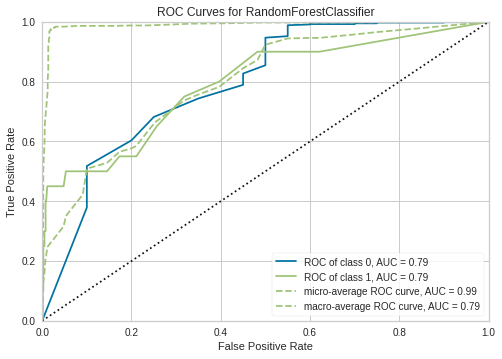

In [37]:
plot_model(rf, plot = 'auc')

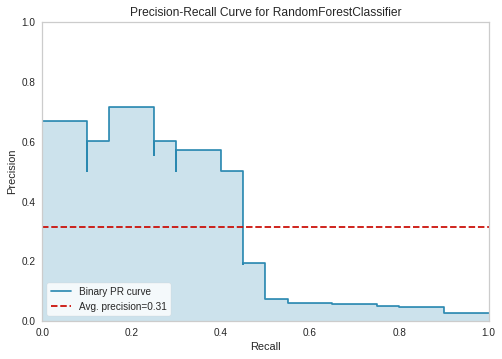

In [38]:
plot_model(rf, plot = 'pr')

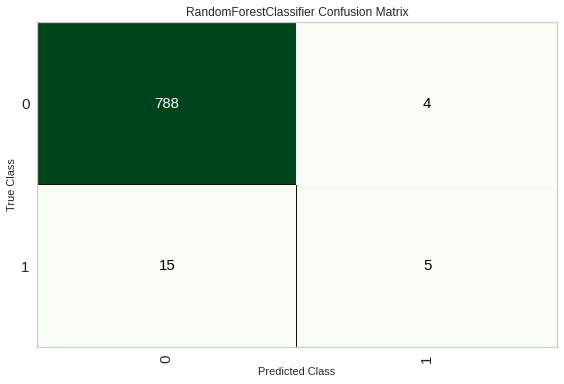

In [39]:
plot_model(rf, plot = 'confusion_matrix')

In [40]:
print(rf)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=-1, oob_score=False, random_state=123, verbose=0,
                       warm_start=False)


# RF - tuned parameter by AUC

In [41]:
tuned_rf_auc = tune_model(rf, optimize = 'AUC')
tuned_rf_auc_df = pull()
tuned_rf_auc_df_name = "tuned_rf_auc_df_"+ss+".csv"
tuned_rf_auc_df.to_csv(tuned_rf_auc_df_name)
tuned_rf_auc_df_path = save_path_m+ss+"/"
!gsutil cp $tuned_rf_auc_df_name $tuned_rf_auc_df_path

Accuracy     AUC  Recall   Prec.      F1   Kappa     MCC
0       0.9384  0.5798  0.2000  0.0833  0.1176  0.0913  0.1008
1       0.9439  0.8195  0.2667  0.1176  0.1633  0.1387  0.1513
2       0.9261  0.7183  0.4000  0.1176  0.1818  0.1550  0.1876
3       0.9480  0.8043  0.4000  0.1714  0.2400  0.2175  0.2387
4       0.9508  0.6564  0.4000  0.1818  0.2500  0.2282  0.2474
5       0.9438  0.9179  0.5714  0.1860  0.2807  0.2593  0.3044
6       0.9603  0.7407  0.5714  0.2581  0.3556  0.3381  0.3668
7       0.9466  0.7015  0.2857  0.1212  0.1702  0.1472  0.1619
8       0.9466  0.7887  0.3571  0.1429  0.2041  0.1817  0.2024
9       0.9315  0.7336  0.2143  0.0714  0.1071  0.0807  0.0941
Mean    0.9436  0.7461  0.3667  0.1451  0.2070  0.1838  0.2055
SD      0.0092  0.0887  0.1244  0.0527  0.0723  0.0748  0.0820

Copying file://tuned_rf_auc_df_TOX21_Aromatase_Inhibition.csv [Content-Type=text/csv]...
/ [1 files][  635.0 B/  635.0 B]                                                
Operation completed over 1 objects/635.0 B.                                      


In [42]:
predict_model(tuned_rf_auc)
tuned_rf_auc_p_df = pull()
tuned_rf_auc_p_df_name = "tuned_rf_auc_p_df_"+ss+".csv"
tuned_rf_auc_p_df.to_csv(tuned_rf_auc_p_df_name)
tuned_rf_auc_p_df_path = save_path_m+ss+"/"
!gsutil cp $tuned_rf_auc_p_df_name $tuned_rf_auc_p_df_path

Model  Accuracy    AUC  ...      F1   Kappa     MCC
0  Random Forest Classifier    0.9507  0.776  ...  0.2857  0.2624  0.2746

[1 rows x 8 columns]

Copying file://tuned_rf_auc_p_df_TOX21_Aromatase_Inhibition.csv [Content-Type=text/csv]...
/ [1 files][  118.0 B/  118.0 B]                                                
Operation completed over 1 objects/118.0 B.                                      


# RF -tuned parameter by F1

In [43]:
tuned_rf_f1 = tune_model(rf, optimize = 'F1')
tuned_rf_f1_df = pull()
tuned_rf_f1_df_name = "tuned_rf_f1_df_"+ss+".csv"
tuned_rf_f1_df.to_csv(tuned_rf_f1_df_name)
tuned_rf_f1_df_path = save_path_m+ss+"/"
!gsutil cp $tuned_rf_f1_df_name $tuned_rf_f1_df_path

Accuracy     AUC  Recall   Prec.      F1   Kappa     MCC
0       0.9384  0.5798  0.2000  0.0833  0.1176  0.0913  0.1008
1       0.9439  0.8195  0.2667  0.1176  0.1633  0.1387  0.1513
2       0.9261  0.7183  0.4000  0.1176  0.1818  0.1550  0.1876
3       0.9480  0.8043  0.4000  0.1714  0.2400  0.2175  0.2387
4       0.9508  0.6564  0.4000  0.1818  0.2500  0.2282  0.2474
5       0.9438  0.9179  0.5714  0.1860  0.2807  0.2593  0.3044
6       0.9603  0.7407  0.5714  0.2581  0.3556  0.3381  0.3668
7       0.9466  0.7015  0.2857  0.1212  0.1702  0.1472  0.1619
8       0.9466  0.7887  0.3571  0.1429  0.2041  0.1817  0.2024
9       0.9315  0.7336  0.2143  0.0714  0.1071  0.0807  0.0941
Mean    0.9436  0.7461  0.3667  0.1451  0.2070  0.1838  0.2055
SD      0.0092  0.0887  0.1244  0.0527  0.0723  0.0748  0.0820

Copying file://tuned_rf_f1_df_TOX21_Aromatase_Inhibition.csv [Content-Type=text/csv]...
/ [1 files][  635.0 B/  635.0 B]                                                
Operation completed over 1 objects/635.0 B.                                      


In [44]:
predict_model(tuned_rf_f1)
tuned_rf_f1_p_df = pull()
tuned_rf_f1_p_df_name = "tuned_rf_f1_p_df_"+ss+".csv"
tuned_rf_f1_p_df.to_csv(tuned_rf_f1_p_df_name)
tuned_rf_f1_p_df_path = save_path_m+ss+"/"
!gsutil cp $tuned_rf_f1_p_df_name $tuned_rf_f1_p_df_path

Model  Accuracy    AUC  ...      F1   Kappa     MCC
0  Random Forest Classifier    0.9507  0.776  ...  0.2857  0.2624  0.2746

[1 rows x 8 columns]

Copying file://tuned_rf_f1_p_df_TOX21_Aromatase_Inhibition.csv [Content-Type=text/csv]...
/ [1 files][  118.0 B/  118.0 B]                                                
Operation completed over 1 objects/118.0 B.                                      


# RF -tuned parameter by Kappa

In [45]:
tuned_rf_kappa = tune_model(rf, optimize = 'Kappa')
tuned_rf_kappa_df = pull()
tuned_rf_kappa_df_name = "tuned_rf_kappa_df_"+ss+".csv"
tuned_rf_kappa_df.to_csv(tuned_rf_kappa_df_name)
tuned_rf_kappa_df_path = save_path_m+ss+"/"
!gsutil cp $tuned_rf_kappa_df_name $tuned_rf_kappa_df_path

Accuracy     AUC  Recall   Prec.      F1   Kappa     MCC
0       0.9384  0.5798  0.2000  0.0833  0.1176  0.0913  0.1008
1       0.9439  0.8195  0.2667  0.1176  0.1633  0.1387  0.1513
2       0.9261  0.7183  0.4000  0.1176  0.1818  0.1550  0.1876
3       0.9480  0.8043  0.4000  0.1714  0.2400  0.2175  0.2387
4       0.9508  0.6564  0.4000  0.1818  0.2500  0.2282  0.2474
5       0.9438  0.9179  0.5714  0.1860  0.2807  0.2593  0.3044
6       0.9603  0.7407  0.5714  0.2581  0.3556  0.3381  0.3668
7       0.9466  0.7015  0.2857  0.1212  0.1702  0.1472  0.1619
8       0.9466  0.7887  0.3571  0.1429  0.2041  0.1817  0.2024
9       0.9315  0.7336  0.2143  0.0714  0.1071  0.0807  0.0941
Mean    0.9436  0.7461  0.3667  0.1451  0.2070  0.1838  0.2055
SD      0.0092  0.0887  0.1244  0.0527  0.0723  0.0748  0.0820

Copying file://tuned_rf_kappa_df_TOX21_Aromatase_Inhibition.csv [Content-Type=text/csv]...
/ [1 files][  635.0 B/  635.0 B]                                                
Operation completed over 1 objects/635.0 B.                                      


In [46]:
predict_model(tuned_rf_kappa)
tuned_rf_kappa_p_df = pull()
tuned_rf_kappa_p_df_name = "tuned_rf_kappa_p_df_"+ss+".csv"
tuned_rf_kappa_p_df.to_csv(tuned_rf_kappa_p_df_name)
tuned_rf_kappa_p_df_path = save_path_m+ss+"/"
!gsutil cp $tuned_rf_kappa_p_df_name $tuned_rf_kappa_p_df_path

Model  Accuracy    AUC  ...      F1   Kappa     MCC
0  Random Forest Classifier    0.9507  0.776  ...  0.2857  0.2624  0.2746

[1 rows x 8 columns]

Copying file://tuned_rf_kappa_p_df_TOX21_Aromatase_Inhibition.csv [Content-Type=text/csv]...
/ [1 files][  118.0 B/  118.0 B]                                                
Operation completed over 1 objects/118.0 B.                                      


# RF -tuned parameter by MCC

In [47]:
tuned_rf_MCC = tune_model(rf, optimize = 'MCC')
tuned_rf_MCC_df = pull()
tuned_rf_MCC_df_name = "tuned_rf_MCC_df_"+ss+".csv"
tuned_rf_MCC_df.to_csv(tuned_rf_MCC_df_name)
tuned_rf_MCC_df_path = save_path_m+ss+"/"
!gsutil cp $tuned_rf_MCC_df_name $tuned_rf_MCC_df_path

Accuracy     AUC  Recall   Prec.      F1   Kappa     MCC
0       0.9384  0.5798  0.2000  0.0833  0.1176  0.0913  0.1008
1       0.9439  0.8195  0.2667  0.1176  0.1633  0.1387  0.1513
2       0.9261  0.7183  0.4000  0.1176  0.1818  0.1550  0.1876
3       0.9480  0.8043  0.4000  0.1714  0.2400  0.2175  0.2387
4       0.9508  0.6564  0.4000  0.1818  0.2500  0.2282  0.2474
5       0.9438  0.9179  0.5714  0.1860  0.2807  0.2593  0.3044
6       0.9603  0.7407  0.5714  0.2581  0.3556  0.3381  0.3668
7       0.9466  0.7015  0.2857  0.1212  0.1702  0.1472  0.1619
8       0.9466  0.7887  0.3571  0.1429  0.2041  0.1817  0.2024
9       0.9315  0.7336  0.2143  0.0714  0.1071  0.0807  0.0941
Mean    0.9436  0.7461  0.3667  0.1451  0.2070  0.1838  0.2055
SD      0.0092  0.0887  0.1244  0.0527  0.0723  0.0748  0.0820

Copying file://tuned_rf_MCC_df_TOX21_Aromatase_Inhibition.csv [Content-Type=text/csv]...
/ [1 files][  635.0 B/  635.0 B]                                                
Operation completed over 1 objects/635.0 B.                                      


In [48]:
predict_model(tuned_rf_MCC)
tuned_rf_MCC_p_df = pull()
tuned_rf_MCC_p_df_name = "tuned_rf_MCC_p_df_"+ss+".csv"
tuned_rf_MCC_p_df.to_csv(tuned_rf_MCC_p_df_name)
tuned_rf_MCC_p_df_path = save_path_m+ss+"/"
!gsutil cp $tuned_rf_MCC_p_df_name $tuned_rf_MCC_p_df_path

Model  Accuracy    AUC  ...      F1   Kappa     MCC
0  Random Forest Classifier    0.9507  0.776  ...  0.2857  0.2624  0.2746

[1 rows x 8 columns]

Copying file://tuned_rf_MCC_p_df_TOX21_Aromatase_Inhibition.csv [Content-Type=text/csv]...
/ [1 files][  118.0 B/  118.0 B]                                                
Operation completed over 1 objects/118.0 B.                                      


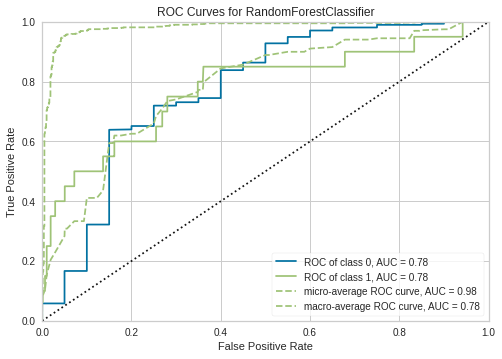

In [49]:
plot_model(tuned_rf_auc, plot = 'auc')

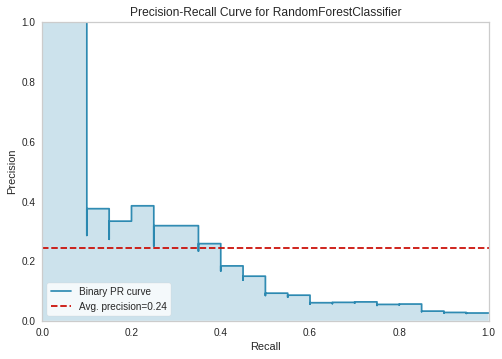

In [50]:
plot_model(tuned_rf_auc, plot = 'pr')

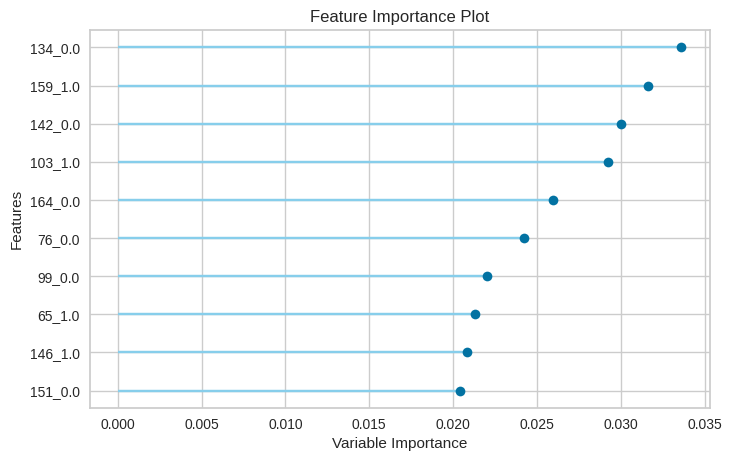

In [51]:
plot_model(tuned_rf_auc, plot='feature')

In [52]:
print(tuned_rf_auc)

RandomForestClassifier(bootstrap=False, ccp_alpha=0.0,
                       class_weight='balanced_subsample', criterion='gini',
                       max_depth=6, max_features='log2', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.001,
                       min_impurity_split=None, min_samples_leaf=6,
                       min_samples_split=9, min_weight_fraction_leaf=0.0,
                       n_estimators=190, n_jobs=-1, oob_score=False,
                       random_state=123, verbose=0, warm_start=False)


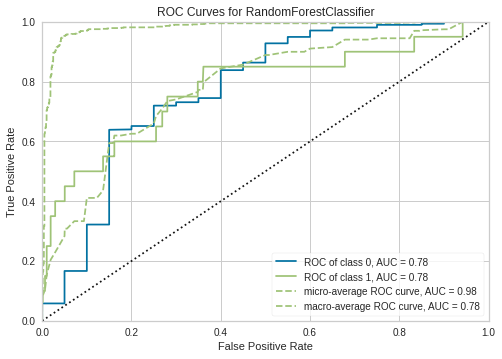

In [53]:
plot_model(tuned_rf_f1, plot = 'auc')

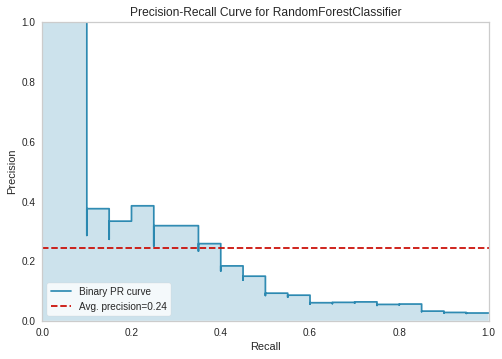

In [54]:
plot_model(tuned_rf_f1, plot = 'pr')

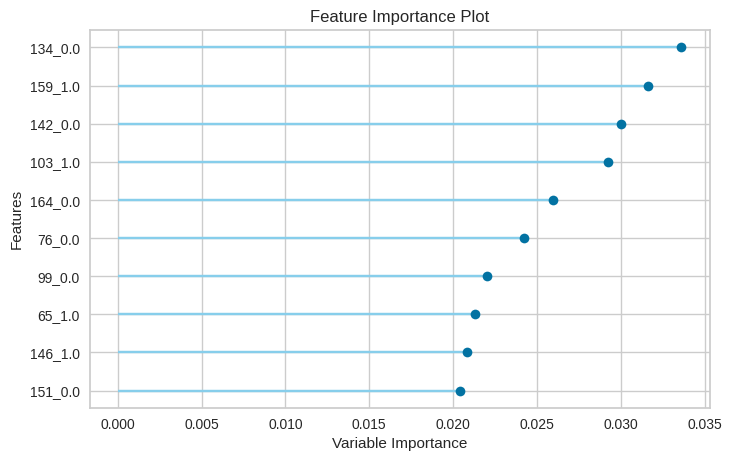

In [55]:
plot_model(tuned_rf_f1, plot='feature')

In [56]:
print(tuned_rf_f1)

RandomForestClassifier(bootstrap=False, ccp_alpha=0.0,
                       class_weight='balanced_subsample', criterion='gini',
                       max_depth=6, max_features='log2', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.001,
                       min_impurity_split=None, min_samples_leaf=6,
                       min_samples_split=9, min_weight_fraction_leaf=0.0,
                       n_estimators=190, n_jobs=-1, oob_score=False,
                       random_state=123, verbose=0, warm_start=False)


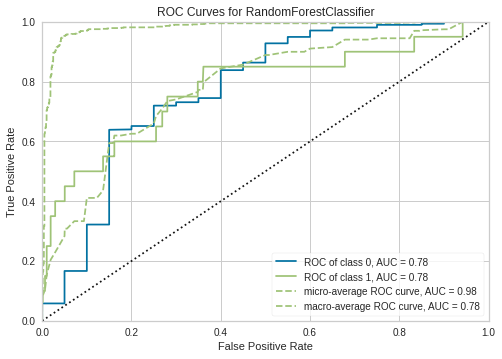

In [57]:
plot_model(tuned_rf_kappa, plot = 'auc')

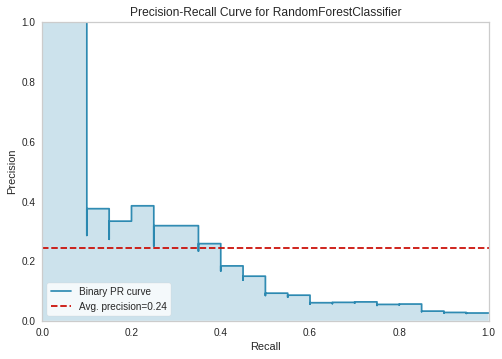

In [58]:
plot_model(tuned_rf_kappa, plot = 'pr')

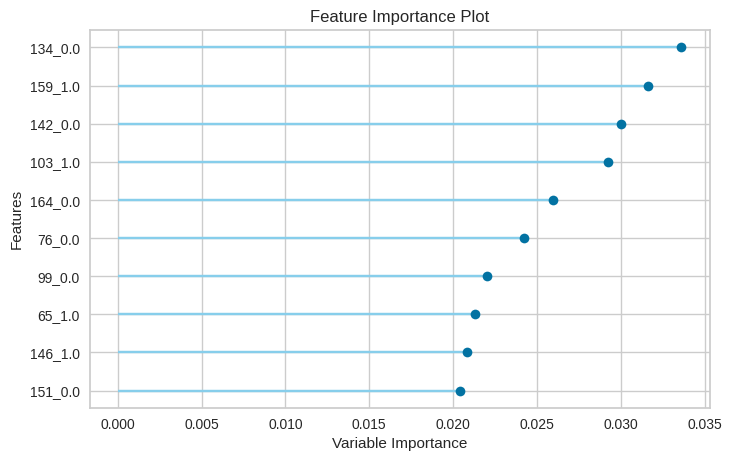

In [59]:
plot_model(tuned_rf_kappa, plot='feature')

In [60]:
print(tuned_rf_kappa)

RandomForestClassifier(bootstrap=False, ccp_alpha=0.0,
                       class_weight='balanced_subsample', criterion='gini',
                       max_depth=6, max_features='log2', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.001,
                       min_impurity_split=None, min_samples_leaf=6,
                       min_samples_split=9, min_weight_fraction_leaf=0.0,
                       n_estimators=190, n_jobs=-1, oob_score=False,
                       random_state=123, verbose=0, warm_start=False)


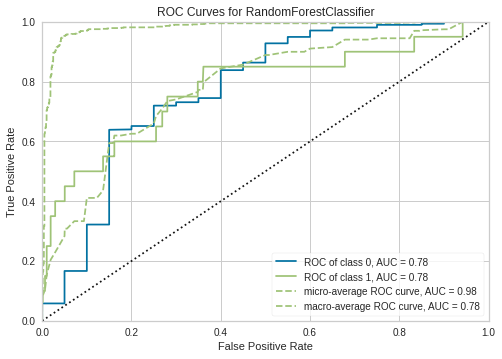

In [61]:
plot_model(tuned_rf_MCC, plot = 'auc')

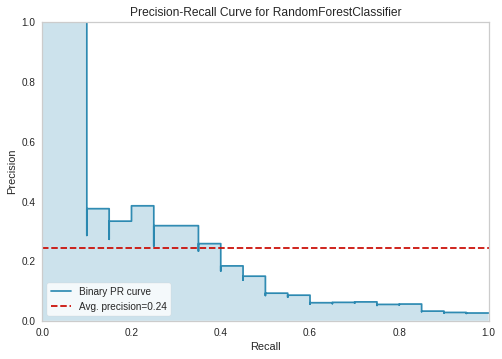

In [62]:
plot_model(tuned_rf_MCC, plot = 'pr')

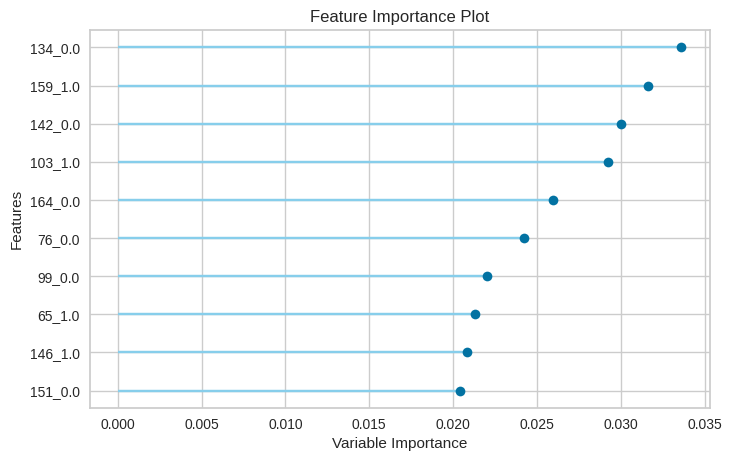

In [63]:
plot_model(tuned_rf_MCC, plot='feature')

In [64]:
print(tuned_rf_MCC)

RandomForestClassifier(bootstrap=False, ccp_alpha=0.0,
                       class_weight='balanced_subsample', criterion='gini',
                       max_depth=6, max_features='log2', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.001,
                       min_impurity_split=None, min_samples_leaf=6,
                       min_samples_split=9, min_weight_fraction_leaf=0.0,
                       n_estimators=190, n_jobs=-1, oob_score=False,
                       random_state=123, verbose=0, warm_start=False)


# all algorithm compare with validation auc

In [65]:
best_specific = compare_models (sort = 'AUC', n_select = 6)
allml_df = pull()
allml_df_name = "allml_df_"+ss+".csv"
allml_df.to_csv(allml_df_name)
allml_df_path save_path+"allml/"+ss+"/"
!gsutil cp $allml_df_name $allml_df_path

SyntaxError: ignored